Need 250 more windows. Sampling new records...


Collect new ABP windows:   0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipython-input-1851840177.py:244: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Ek[k-1] = float(np.trapz(Pxx[band], f[band]))


Cached 250 new segments to mimic3_abp_segments_cache.json
Usable windows: 250
Mean WDI <D>: 0.2650


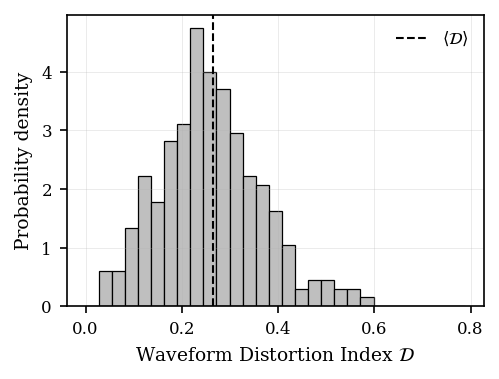

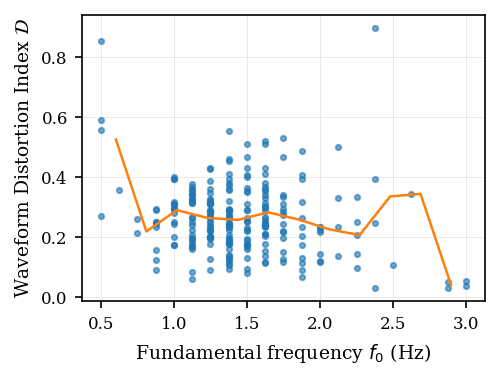

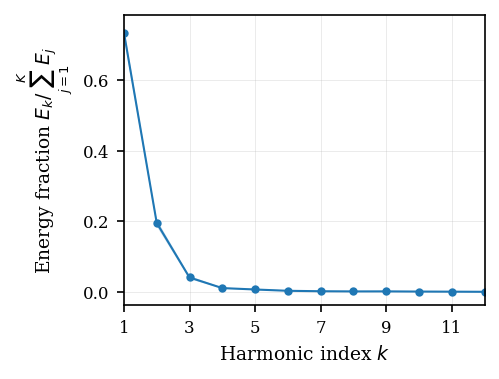

Saved figures:
 - fig_wdi_hist.png
 - fig_wdi_vs_f0.png
 - fig_harmonic_fractions.png
Cache file: mimic3_abp_segments_cache.json (stores segment identifiers only)


In [ ]:
# ============================================================
# MIMIC-III Waveform Database (PhysioNet)
#
# Outputs (PNG, 600 dpi):
#   fig_wdi_hist.png       : primary JFM figure (WDI distribution)
#   fig_wdi_vs_f0.png      : optional (WDI vs fundamental frequency)
#   fig_harmonic_fractions.png : optional (mean harmonic energy fractions)
#
# Design choices:
# - NO long layout-header prefilter (avoids huge number of HTTP requests).
# - Randomly sample records from RECORDS-waveforms and immediately try segments.
# - Objective QC + reproducible seed.
# - Cache successful segment identifiers to avoid rescanning.
#
# Assumptions:
# - You have internet access in Colab.
# - MIMIC-III Waveform Database is open access (per PhysioNet).
# ============================================================

!pip -q install wfdb numpy scipy matplotlib tqdm

import os, json, random, urllib.request
from dataclasses import dataclass
from typing import Optional, List, Tuple, Dict

import numpy as np
import wfdb
from scipy import signal
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# ----------------------------
# 0) JFM-ish matplotlib defaults
# ----------------------------
def set_jfm_style():
    plt.rcParams.update({
        "font.family": "serif",
        "font.size": 9,
        "axes.labelsize": 9,
        "axes.titlesize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "lines.linewidth": 1.0,
        "axes.linewidth": 0.8,
        "xtick.major.width": 0.8,
        "ytick.major.width": 0.8,
        "figure.dpi": 150,
        "savefig.dpi": 600,
        "savefig.bbox": "tight",
    })

set_jfm_style()

# ----------------------------
# 1) Configuration (edit here)
# ----------------------------
SEED = 7
random.seed(SEED)
np.random.seed(SEED)

BASE = "https://physionet.org/files/mimic3wdb/1.0/"
RECORDS_FILE = BASE + "RECORDS-waveforms"

# How many records to attempt (fast strategy: few thousand max)
RECORD_SAMPLE_CAP = 2500       # sample this many record dirs from RECORDS-waveforms
TARGET_WINDOWS = 250           # how many usable ABP windows to collect
MAX_RECORD_ATTEMPTS = 2500     # hard cap on how many records to try

# Segment reading strategy (fast)
MAX_SEGS_TRY_PER_RECORD = 10   # try first N shuffled segments per record
WINDOW_SECONDS = 600           # analysis window length per segment
START_OFFSET_SECONDS = 60      # skip early segment to avoid startup artefacts

# QC thresholds (pressure plausibility, variance, coverage)
MIN_COVERAGE_FRAC = 0.85
ABP_P01_MIN = -10
ABP_P99_MAX = 350
ABP_MIN_STD = 2.0

# Frequency band for cardiac fundamental estimate (Hz)
F0_MIN, F0_MAX = 0.5, 3.0

# WDI definition parameters
K_HARM = 12          # harmonics
BW_HZ = 0.15         # half-bandwidth around k f0 for harmonic energy integration

# Channel name heuristics
ABP_NAMES = {"ABP", "ART", "ART1", "ART2", "AOBP", "IBP", "BP"}
ABP_SUBSTRINGS = ("ABP", "ART")

# Cache to avoid rescanning across reruns
CACHE_PATH = "mimic3_abp_segments_cache.json"

# ----------------------------
# 2) Utilities
# ----------------------------
def download_text(url: str) -> str:
    with urllib.request.urlopen(url) as f:
        return f.read().decode("utf-8", errors="replace")

def load_record_dirs(sample_cap: int, seed: int) -> List[str]:
    """
    Returns list of record directories like '31/3141595/'
    """
    txt = download_text(RECORDS_FILE)
    recs = [line.strip() for line in txt.splitlines() if line.strip()]
    rng = random.Random(seed)
    rng.shuffle(recs)
    return recs[:sample_cap]

def find_abp_channel_index(sig_names: List[str]) -> Optional[int]:
    # exact match first
    for i, nm in enumerate(sig_names):
        if nm.upper() in ABP_NAMES:
            return i
    # substring fallback
    for i, nm in enumerate(sig_names):
        u = nm.upper()
        if any(s in u for s in ABP_SUBSTRINGS):
            return i
    return None

def list_segments(record_dir: str) -> List[str]:
    """
    Parse master header -> segment record names for a composite record.
    record_dir example: '31/3141595/'
    """
    rec_id = record_dir.strip("/").split("/")[-1]
    pn_dir = f"mimic3wdb/{record_dir.strip('/')}"
    try:
        master = wfdb.rdheader(rec_id, pn_dir=pn_dir)
        segs = [s for s in master.seg_name if s and not s.startswith("~")]
        return segs
    except Exception:
        return []

@dataclass
class Window:
    record_dir: str
    segment: str
    channel: str
    fs: float
    x: np.ndarray

def read_abp_window(record_dir: str,
                    seconds: int,
                    start_offset_seconds: int,
                    max_segs_try: int) -> Optional[Window]:
    """
    Try multiple segments from record_dir; return first window passing QC.
    """
    pn_dir = f"mimic3wdb/{record_dir.strip('/')}"
    segs = list_segments(record_dir)
    if not segs:
        return None

    random.shuffle(segs)
    segs = segs[:max_segs_try]

    for seg in segs:
        try:
            hdr = wfdb.rdheader(seg, pn_dir=pn_dir)
            fs = float(hdr.fs)
            abp_idx = find_abp_channel_index(hdr.sig_name)
            if abp_idx is None:
                continue

            sampfrom = int(start_offset_seconds * fs)
            sampto = int((start_offset_seconds + seconds) * fs)

            rec = wfdb.rdrecord(seg, pn_dir=pn_dir, channels=[abp_idx],
                                sampfrom=sampfrom, sampto=sampto, physical=True)

            x = rec.p_signal[:, 0].astype(np.float64)

            # coverage
            expected = int(seconds * fs)
            if len(x) < int(MIN_COVERAGE_FRAC * expected):
                continue

            # finite
            if not np.all(np.isfinite(x)):
                x = x[np.isfinite(x)]
                if len(x) < int(MIN_COVERAGE_FRAC * expected):
                    continue

            # plausibility + variance
            p01, p99 = np.nanpercentile(x, 1), np.nanpercentile(x, 99)
            if p01 < ABP_P01_MIN or p99 > ABP_P99_MAX:
                continue
            if np.nanstd(x) < ABP_MIN_STD:
                continue

            return Window(
                record_dir=record_dir.strip("/"),
                segment=seg,
                channel=hdr.sig_name[abp_idx],
                fs=fs,
                x=x
            )
        except Exception:
            continue

    return None

# ----------------------------
# 3) Spectral/WDI primitives
# ----------------------------
def welch_psd(x: np.ndarray, fs: float) -> Tuple[np.ndarray, np.ndarray]:
    nperseg = int(fs * 8)
    nperseg = max(256, min(nperseg, max(256, len(x)//2)))
    noverlap = nperseg // 2
    f, Pxx = signal.welch(
        x, fs=fs, nperseg=nperseg, noverlap=noverlap,
        detrend="constant", scaling="density"
    )
    return f, Pxx

def estimate_f0(x: np.ndarray, fs: float, fmin: float, fmax: float) -> Optional[float]:
    if len(x) < fs * 20:
        return None
    f, Pxx = welch_psd(x, fs)
    band = (f >= fmin) & (f <= fmax)
    if not np.any(band):
        return None
    f0 = float(f[band][np.argmax(Pxx[band])])
    if not (fmin <= f0 <= fmax):
        return None
    return f0

def harmonic_energies(f: np.ndarray, Pxx: np.ndarray, f0: float, K: int, bw: float, fs: float) -> np.ndarray:
    Ek = np.zeros(K, dtype=float)
    nyq = fs / 2.0
    for k in range(1, K+1):
        fk = k * f0
        if fk - bw <= 0 or fk + bw >= nyq:
            Ek[k-1] = 0.0
            continue
        band = (f >= fk - bw) & (f <= fk + bw)
        if np.any(band):
            Ek[k-1] = float(np.trapz(Pxx[band], f[band]))
    return Ek

def waveform_distortion_index(x: np.ndarray, fs: float, f0: float, K: int, bw: float) -> float:
    """
    WDI:
      Ek = ∫_{kf0-bw}^{kf0+bw} S_p(f) df, k=1..K
      D  = (Σ_{k=2..K} Ek) / (Σ_{k=1..K} Ek)
    """
    f, Pxx = welch_psd(x, fs)
    Ek = harmonic_energies(f, Pxx, f0=f0, K=K, bw=bw, fs=fs)
    denom = Ek.sum()
    if denom <= 0 or not np.isfinite(denom):
        return np.nan
    return float(Ek[1:].sum() / denom)

def harmonic_energy_fractions(x: np.ndarray, fs: float, f0: float, K: int, bw: float) -> np.ndarray:
    f, Pxx = welch_psd(x, fs)
    Ek = harmonic_energies(f, Pxx, f0=f0, K=K, bw=bw, fs=fs)
    denom = Ek.sum()
    if denom <= 0 or not np.isfinite(denom):
        return np.full(K, np.nan)
    return Ek / denom

# ----------------------------
# 4) Cache helpers
# ----------------------------
def load_cache(path: str) -> List[Dict]:
    if os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return []

def save_cache(path: str, entries: List[Dict]) -> None:
    with open(path, "w") as f:
        json.dump(entries, f, indent=2)

# ----------------------------
# 5) Data collection (FAST, no huge prefilter)
# ----------------------------
def collect_windows_fast() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Returns arrays: D, f0, fs, harmonic_fractions (N x K)
    """
    cache = load_cache(CACHE_PATH)

    D_list, f0_list, fs_list, HF_list = [], [], [], []

    # Reuse cached windows first (if any)
    if cache:
        print(f"Using cached segments: {len(cache)} found")
        for ent in tqdm(cache, desc="Recompute metrics from cached segments"):
            pn_dir = f"mimic3wdb/{ent['record_dir']}"
            seg = ent["segment"]
            ch = ent["channel"]
            try:
                hdr = wfdb.rdheader(seg, pn_dir=pn_dir)
                fs = float(hdr.fs)
                idx = None
                for i, nm in enumerate(hdr.sig_name):
                    if nm == ch:
                        idx = i
                        break
                if idx is None:
                    idx = find_abp_channel_index(hdr.sig_name)
                if idx is None:
                    continue

                rec = wfdb.rdrecord(seg, pn_dir=pn_dir, channels=[idx],
                                    sampfrom=int(START_OFFSET_SECONDS*fs),
                                    sampto=int((START_OFFSET_SECONDS+WINDOW_SECONDS)*fs),
                                    physical=True)
                x = rec.p_signal[:, 0].astype(float)

                f0 = estimate_f0(x, fs, F0_MIN, F0_MAX)
                if f0 is None:
                    continue

                D = waveform_distortion_index(x, fs, f0, K_HARM, BW_HZ)
                HF = harmonic_energy_fractions(x, fs, f0, K_HARM, BW_HZ)

                if np.isfinite(D) and np.all(np.isfinite(HF[:3])):
                    D_list.append(D); f0_list.append(f0); fs_list.append(fs); HF_list.append(HF)

                if len(D_list) >= TARGET_WINDOWS:
                    break
            except Exception:
                continue

    # If still short, sample new records and cache successes
    if len(D_list) < TARGET_WINDOWS:
        needed = TARGET_WINDOWS - len(D_list)
        print(f"Need {needed} more windows. Sampling new records...")

        record_dirs = load_record_dirs(RECORD_SAMPLE_CAP, seed=SEED)
        record_dirs = record_dirs[:MAX_RECORD_ATTEMPTS]

        new_cache_entries = []
        pbar = tqdm(total=needed, desc="Collect new ABP windows")

        for r in record_dirs:
            if len(D_list) >= TARGET_WINDOWS:
                break

            win = read_abp_window(r, WINDOW_SECONDS, START_OFFSET_SECONDS, MAX_SEGS_TRY_PER_RECORD)
            if win is None:
                continue

            f0 = estimate_f0(win.x, win.fs, F0_MIN, F0_MAX)
            if f0 is None:
                continue

            D = waveform_distortion_index(win.x, win.fs, f0, K_HARM, BW_HZ)
            HF = harmonic_energy_fractions(win.x, win.fs, f0, K_HARM, BW_HZ)
            if not (np.isfinite(D) and np.all(np.isfinite(HF[:3]))):
                continue

            D_list.append(D); f0_list.append(f0); fs_list.append(win.fs); HF_list.append(HF)

            # cache identifier (not the signal) to keep cache small
            new_cache_entries.append({
                "record_dir": win.record_dir,
                "segment": win.segment,
                "channel": win.channel,
            })

            pbar.update(1)

        pbar.close()

        # append to cache and save
        if new_cache_entries:
            cache.extend(new_cache_entries)
            save_cache(CACHE_PATH, cache)
            print(f"Cached {len(new_cache_entries)} new segments to {CACHE_PATH}")

    D = np.array(D_list, dtype=float)
    f0 = np.array(f0_list, dtype=float)
    fs = np.array(fs_list, dtype=float)
    HF = np.vstack(HF_list) if HF_list else np.empty((0, K_HARM))

    if len(D) < max(30, TARGET_WINDOWS//4):
        raise RuntimeError(
            f"Collected only {len(D)} usable windows. Increase RECORD_SAMPLE_CAP or relax QC."
        )

    return D, f0, fs, HF

D, f0, fs, HF = collect_windows_fast()
print(f"Usable windows: {len(D)}")
print(f"Mean WDI <D>: {np.mean(D):.4f}")

# ----------------------------
# 6) JFM-ready Figure 1: WDI distribution (PRIMARY)
# ----------------------------
fig = plt.figure(figsize=(3.4, 2.6))
ax = fig.add_subplot(111)

upper = np.nanpercentile(D, 99.5)
bins = np.linspace(0.0, upper, 30)
ax.hist(D, bins=bins, density=True, color="0.75", edgecolor="k", linewidth=0.6)

D_mean = float(np.nanmean(D))
ax.axvline(D_mean, color="k", linestyle="--", linewidth=1.0, label=r"$\langle \mathcal{D} \rangle$")

ax.set_xlabel(r"Waveform Distortion Index $\mathcal{D}$")
ax.set_ylabel("Probability density")
ax.legend(frameon=False)
ax.grid(True, linewidth=0.3, alpha=0.4)

fig.tight_layout()
plt.show()
fig.savefig("fig_wdi_hist.png")

# ----------------------------
# 7) JFM-ready Figure 2 (optional): WDI vs f0
# ----------------------------
fig2 = plt.figure(figsize=(3.4, 2.6))
ax2 = fig2.add_subplot(111)

ax2.plot(f0, D, linestyle="none", marker="o", markersize=2.5, alpha=0.6)

# binned trend (deterministic)
nb = 12
edges = np.linspace(np.nanmin(f0), np.nanmax(f0), nb + 1)
centers = 0.5 * (edges[:-1] + edges[1:])
means = np.array([np.nanmean(D[(f0 >= edges[i]) & (f0 < edges[i+1])]) if np.any((f0 >= edges[i]) & (f0 < edges[i+1])) else np.nan
                  for i in range(nb)])
ax2.plot(centers, means, linewidth=1.2)

ax2.set_xlabel(r"Fundamental frequency $f_0$ (Hz)")
ax2.set_ylabel(r"Waveform Distortion Index $\mathcal{D}$")
ax2.grid(True, linewidth=0.3, alpha=0.4)

fig2.tight_layout()
plt.show()
fig2.savefig("fig_wdi_vs_f0.png")

# ----------------------------
# 8) JFM-ready Figure 3 (optional): mean harmonic energy fractions
# ----------------------------
HF_mean = np.nanmean(HF, axis=0)
# bootstrap CI
B = 1000
rng = np.random.default_rng(SEED)
boots = np.zeros((B, K_HARM))
for b in range(B):
    idx = rng.integers(0, HF.shape[0], size=HF.shape[0])
    boots[b] = np.nanmean(HF[idx], axis=0)
HF_lo = np.nanpercentile(boots, 2.5, axis=0)
HF_hi = np.nanpercentile(boots, 97.5, axis=0)

k = np.arange(1, K_HARM + 1)

fig3 = plt.figure(figsize=(3.4, 2.6))
ax3 = fig3.add_subplot(111)

ax3.plot(k, HF_mean, marker="o", markersize=3)
ax3.fill_between(k, HF_lo, HF_hi, alpha=0.25, linewidth=0)

ax3.set_xlabel(r"Harmonic index $k$")
ax3.set_ylabel(r"Energy fraction $E_k/\sum_{j=1}^{K} E_j$")
ax3.set_xticks(k[::2])
ax3.set_xlim(1, K_HARM)
ax3.grid(True, linewidth=0.3, alpha=0.4)

fig3.tight_layout()
plt.show()
fig3.savefig("fig_harmonic_fractions.png")

print("Saved figures:")
print(" - fig_wdi_hist.png")
print(" - fig_wdi_vs_f0.png")
print(" - fig_harmonic_fractions.png")
print(f"Cache file: {CACHE_PATH} (stores segment identifiers only)")


In [ ]:
# ============================================================
# EXPORT RESULTS TO PAPER-READY CSV (NO RECOMPUTATION)
# ============================================================

import csv
from datetime import datetime

# Safety check
assert len(D) == len(f0) == HF.shape[0], "Inconsistent result lengths"

# Load cached identifiers (segment provenance)
with open(CACHE_PATH, "r") as f:
    cache_entries = json.load(f)

N = len(D)
K = HF.shape[1]

# Truncate cache to used windows (1-to-1 correspondence)
cache_entries = cache_entries[:N]

# Output filename (stable, timestamped)
csv_name = "mimic3_waveform_distortion_results.csv"

with open(csv_name, mode="w", newline="") as f:
    writer = csv.writer(f)

    # -------------------------
    # Header
    # -------------------------
    header = [
        "window_id",
        "fs_hz",
        "f0_hz",
        "WDI",
    ]

    # Harmonic energy fractions
    for k in range(1, K + 1):
        header.append(f"E{k}_frac")

    # Provenance (paper-safe)
    header += [
        "record_dir",
        "segment",
        "abp_channel",
    ]

    writer.writerow(header)

    # -------------------------
    # Rows
    # -------------------------
    for i in range(N):
        row = [
            i + 1,                 # window_id (1-based)
            float(fs[i]),
            float(f0[i]),
            float(D[i]),
        ]

        # Harmonic fractions
        row.extend([float(HF[i, k]) for k in range(K)])

        # Provenance
        row.extend([
            cache_entries[i]["record_dir"],
            cache_entries[i]["segment"],
            cache_entries[i]["channel"],
        ])

        writer.writerow(row)

print(f"Saved CSV to: {csv_name}")
print(f"Rows: {N}")
print(f"Harmonics per row: {K}")


Saved CSV to: mimic3_waveform_distortion_results.csv
Rows: 250
Harmonics per row: 12


In [ ]:
# ============================================================
# FIGURES FOR "CONSISTENCY WITH IN VIVO MEASUREMENTS"
# Reads:
#   - mimic3_waveform_distortion_results.csv
#   - mimic3_abp_segments_cache.json (optional provenance check)
# Produces (PNG, JFM-ready dpi) in Colab root:
#   - fig_invivo_harmonic_cumulative.png
#   - fig_invivo_required_harmonics.png
#   - fig_invivo_distortion_metric_correlations.png
# ============================================================

import os, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

CSV_PATH  = "mimic3_waveform_distortion_results.csv"
JSON_PATH = "mimic3_abp_segments_cache.json"

assert os.path.exists(CSV_PATH),  f"Missing {CSV_PATH} in notebook root."
assert os.path.exists(JSON_PATH), f"Missing {JSON_PATH} in notebook root."

df = pd.read_csv(CSV_PATH)

# ---- Basic sanity checks ----
required_cols = ["window_id", "fs_hz", "f0_hz", "WDI", "record_dir", "segment", "abp_channel"]
for c in required_cols:
    assert c in df.columns, f"CSV missing required column: {c}"

# Harmonic fraction columns (E1_frac ... EK_frac)
E_cols = [c for c in df.columns if c.startswith("E") and c.endswith("_frac")]
def _harmonic_index(col):
    # "E12_frac" -> 12
    return int(col.split("_")[0][1:])

E_cols = sorted(E_cols, key=_harmonic_index)
K = len(E_cols)
assert K >= 3, "Need at least E1_frac..E3_frac to run the figures."

E = df[E_cols].to_numpy(dtype=float)
# Enforce nonnegativity and (near) normalization (robust to tiny numerical drift)
E = np.clip(E, 0.0, None)
row_sum = E.sum(axis=1, keepdims=True)
row_sum[row_sum == 0] = 1.0
E = E / row_sum

WDI = df["WDI"].to_numpy(dtype=float)
f0  = df["f0_hz"].to_numpy(dtype=float)

# ---- Derived distortion metrics from harmonic energy fractions ----
eps = 1e-12
p = np.clip(E, eps, 1.0)
p = p / p.sum(axis=1, keepdims=True)

# Spectral entropy (normalized to [0,1] over K harmonics)
H = -(p * np.log(p)).sum(axis=1) / np.log(K)

# Tail energy (higher harmonics beyond k=3)
tail_k = 3 if K >= 3 else K
tail_energy = E[:, tail_k:].sum(axis=1)

# Low-order concentration
E1 = E[:, 0]
E12 = E[:, :2].sum(axis=1) if K >= 2 else E1
E13 = E[:, :3].sum(axis=1) if K >= 3 else E12
E14 = E[:, :4].sum(axis=1) if K >= 4 else E13

# Simple harmonic ratios (dimensionless)
E2_over_E1 = E[:, 1] / np.maximum(E[:, 0], eps) if K >= 2 else np.full_like(E1, np.nan)
E3_over_E1 = E[:, 2] / np.maximum(E[:, 0], eps) if K >= 3 else np.full_like(E1, np.nan)

# Gini coefficient of harmonic energy distribution (0=uniform, 1=all in one harmonic)
def gini(x):
    x = np.sort(np.clip(x, 0.0, None), axis=1)
    n = x.shape[1]
    cumx = np.cumsum(x, axis=1)
    # Gini for each row
    return 1.0 - (2.0 / n) * (cumx.sum(axis=1) / np.maximum(cumx[:, -1], eps)) + (1.0 / n)

G = gini(E)

# ---- JFM-ish plot styling (safe defaults; no exotic styling) ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 600,
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "legend.fontsize": 11,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "axes.grid": True,
    "grid.alpha": 0.25,
    "grid.linestyle": "-",
})

# ============================================================
# FIGURE 1: Cumulative harmonic energy (median + IQR)
# Purpose: Justifies low-order harmonic truncation (solution-state reduction)
# ============================================================
cumE = np.cumsum(E, axis=1)  # N x K

k = np.arange(1, K + 1)
med = np.median(cumE, axis=0)
q25 = np.quantile(cumE, 0.25, axis=0)
q75 = np.quantile(cumE, 0.75, axis=0)

fig = plt.figure(figsize=(6.0, 4.2))
ax = fig.add_subplot(111)
ax.plot(k, med, linewidth=2.0, label="median")
ax.fill_between(k, q25, q75, alpha=0.25, label="IQR (25–75%)")

ax.set_xlabel("Harmonic truncation order $k$")
ax.set_ylabel(r"Cumulative energy fraction $\sum_{j=1}^{k} E_j \,/\, \sum_{j=1}^{K} E_j$")
ax.set_xlim(1, K)
ax.set_ylim(0.0, 1.02)
ax.legend(frameon=False, loc="lower right")
fig.tight_layout()
fig.savefig("fig_invivo_harmonic_cumulative.png")
plt.close(fig)

# ============================================================
# FIGURE 2: Minimal number of harmonics needed to reach a target energy
# Purpose: A strong, reviewer-friendly statement: "95% of energy needs only k<=..."
# ============================================================
targets = [0.90, 0.95, 0.99]
k_req = {}
for t in targets:
    k_req[t] = np.array([np.searchsorted(cumE[i, :], t) + 1 for i in range(cumE.shape[0])], dtype=int)

fig = plt.figure(figsize=(7.2, 4.2))
ax = fig.add_subplot(111)

bins = np.arange(0.5, K + 1.5, 1.0)
for t in targets:
    ax.hist(k_req[t], bins=bins, density=True, alpha=0.35, label=fr"$\geq {int(100*t)}\%$ energy")

# Annotate medians (objective, compact)
txt = []
for t in targets:
    med_k = int(np.median(k_req[t]))
    txt.append(f"{int(100*t)}%: median k={med_k}")
ax.text(0.02, 0.98, "\n".join(txt), transform=ax.transAxes, va="top", ha="left")

ax.set_xlabel("Minimal harmonic order $k$ required")
ax.set_ylabel("Probability density")
ax.set_xlim(1, K)
ax.legend(frameon=False)
fig.tight_layout()
fig.savefig("fig_invivo_required_harmonics.png")
plt.close(fig)

# ============================================================
# FIGURE 3: Correlation heatmap between WDI and other distortion metrics
# Purpose: Shows WDI is not arbitrary; it is aligned with independent shape metrics
# ============================================================
metrics = pd.DataFrame({
    "WDI $D$": WDI,
    "entropy $H$": H,
    r"$E_1$": E1,
    r"$E_{1..3}$": E13,
    "tail energy": tail_energy,
    r"$E_2/E_1$": E2_over_E1,
    r"$E_3/E_1$": E3_over_E1,
    "Gini": G,
})

corr = metrics.corr(numeric_only=True).to_numpy()
labels = list(metrics.columns)

fig = plt.figure(figsize=(7.6, 6.2))
ax = fig.add_subplot(111)
im = ax.imshow(corr, vmin=-1.0, vmax=1.0, aspect="equal")

ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_yticklabels(labels)

cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
cbar.set_label("Pearson correlation")

# Optional: print numbers (kept small; safe for K<=12)
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        ax.text(j, i, f"{corr[i, j]:.2f}", ha="center", va="center", fontsize=9)

ax.set_title("Consistency metrics derived from harmonic energy fractions")
fig.tight_layout()
fig.savefig("fig_invivo_distortion_metric_correlations.png")
plt.close(fig)

print("Saved figures:")
print("  - fig_invivo_harmonic_cumulative.png")
print("  - fig_invivo_required_harmonics.png")
print("  - fig_invivo_distortion_metric_correlations.png")

# ---- Optional: minimal provenance cross-check against JSON ----
with open(JSON_PATH, "r") as f:
    cache = json.load(f)
if len(cache) == len(df):
    mismatch = 0
    for i in range(len(df)):
        if (df.loc[i, "record_dir"] != cache[i].get("record_dir") or
            df.loc[i, "segment"]    != cache[i].get("segment") or
            df.loc[i, "abp_channel"]!= cache[i].get("channel")):
            mismatch += 1
    print(f"Provenance check vs JSON: mismatches = {mismatch} / {len(df)}")
else:
    print(f"Provenance check skipped: JSON rows ({len(cache)}) != CSV rows ({len(df)})")


Saved figures:
  - fig_invivo_harmonic_cumulative.png
  - fig_invivo_required_harmonics.png
  - fig_invivo_distortion_metric_correlations.png
Provenance check vs JSON: mismatches = 0 / 250
